In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):

    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{ %s | data : %.4f | grad : %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)


    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot
        
        

In [6]:
class Value: 

    def __init__(self,data, _children=(), _op='', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op = '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data , (self, other), _op = '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward 
        
        return out
    
    def __pow__(self, pow):
        assert isinstance(pow, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** pow, (self,) , _op = f'**{pow}')

        def _backward():
            self.grad += (pow * self.data**(pow-1)) * out.grad
        out._backward = _backward
        
        return out
        
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), _op='exp')

        def _backward():
            self.grad += out.grad * out.data

        out._backward = _backward
        
        return out
        
        
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), _op = 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
    
        
        return out

    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    

    


In [7]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')

b = Value(6.88, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label='o'

# e = (2*n).exp();  e.label="exp2n"
# o = (e-1)/(e+1); o.label="o"


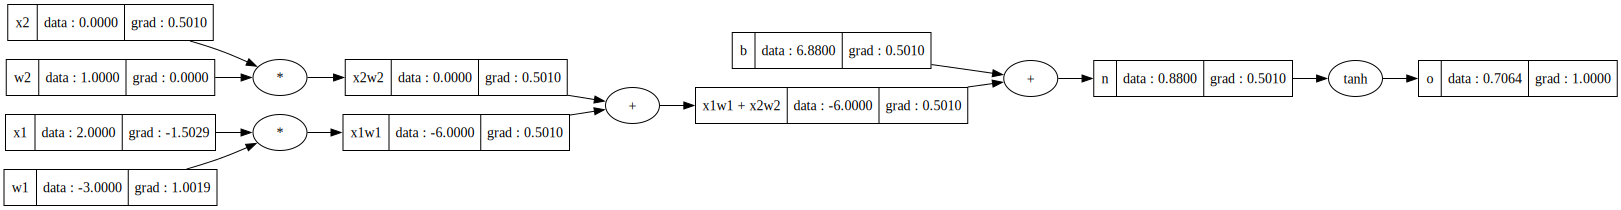

In [8]:
o.backward()
draw_dot(o)


In [2]:
import random

class Neuron():

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        

    def __call__(self, x) :
        
        act = sum((xi*wi for wi, xi in zip(self.w, x)),b)
        # print("w is",self.w)
        # print("b is",self.b)
        out = act.tanh()
        
        return out 

    def parameters(self):
        return self.w + [self.b]
        

class Layer():

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]

        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP():

    def __init__(self,nin,nouts):
        sz=[nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x 

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [3]:

x = [2.0,3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)


NameError: name 'Value' is not defined

In [4]:
ys = [1,-1,-1,1]
ypred = [n(x) for x in xs]
ypred


NameError: name 'xs' is not defined

In [1042]:
ypred = [n(x) for x in xs]
loss = sum((y_p - y_gt)**2 for y_gt, y_p in zip(ys, ypred))
loss

Value(data=7.9999830867529145)

In [1065]:
for k in range(10):

    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt,yout in zip(ys, ypred))
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)
    
    

0 7.9999830867529145
1 7.9999830867529145
2 7.9999830867529145
3 7.9999830867529145
4 7.9999830867529145
5 7.9999830867529145
6 7.9999830867529145
7 7.9999830867529145
8 7.9999830867529145
9 7.9999830867529145


In [1038]:
ypred

[Value(data=0.9999978858418795),
 Value(data=0.9999978858418795),
 Value(data=0.9999978858418795),
 Value(data=0.9999978858418795)]

In [1086]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.tanh() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'TanH' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [1226]:
x = [2.0,3.0, -1.0]
n = MLP(3,[4,4,1])


In [1230]:
xs = [
    [2.0,3.0, -1.0],
    [3.0,-1.0, 0.5],
    [0.5,1.0, 1.0],
    [1.0,1.0, -1.0]
]

ys = [1, -1, -1, 1]

ypred = [n(x) for x in xs]

In [1282]:
for epoch in range(10):

    ypred = [n(x) for x in xs]
    for p in n.parameters():
        p.grad = 0
    
    loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))
    loss.backward()
    for p in n.parameters():
        p.data += - 0.01 * p.grad

    print(epoch, loss.data)
    
    

0 0.009609556336359196
1 0.009571893811408733
2 0.009534521998672048
3 0.00949743757921689
4 0.009460637284055473
5 0.009424117893214089
6 0.009387876234823555
7 0.009351909184229379
8 0.009316213663121624
9 0.009280786638684209


In [1283]:
ypred

[Value(data=0.9468619823267438),
 Value(data=-0.9797295272028248),
 Value(data=-0.9497715817767145),
 Value(data=0.9406421727839822)]